In [1]:
from AG_simple import AlgoritmoGenetico
from sumolib import checkBinary
import xml.etree.ElementTree as ET
import traci
import sys

from statistics import mean, stdev
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def simulate(program):
    traci.start([checkBinary(program), "-c", "sumo-multi/light.sumocfg", "--tripinfo-output", "sumo-multi/tripinfo.xml"])
    
    while traci.simulation.getMinExpectedNumber() > 0:
        traci.simulationStep()
        
    traci.close()
    sys.stdout.flush()
    
    xmldoc = ET.parse('sumo-multi/tripinfo.xml')

    tripinfos = xmldoc.findall('tripinfo')

    waitingTime = 0
    travelTime = 0
    for tripinfo in tripinfos:
        waitingTime += float(tripinfo.get('waitingTime'))
        travelTime += float(tripinfo.get('duration'))
        
    return waitingTime, travelTime

In [3]:
def display(fenotipo):
    red = ET.parse('sumo-multi/light.net.xml')
    signal = red.find('tlLogic')
    fases = signal.findall('phase')
    
    for i in range(4):
        fases[i].set("duration", str(fenotipo[2*i]))
        fases[i].set("state", fenotipo[2*i+1])

    red.write("sumo-multi/light.net.xml")

    return simulate('sumo-gui')

In [4]:
prueba = [30, 'GGGGgrrrrrGGGGgrrrrr', 5, 'yyyyyrrrrryyyyyrrrrr', 30, 'rrrrrGGGGgrrrrrGGGGg', 5, 'rrrrryyyyyrrrrryyyyy']
display(prueba)

(322.79999999999995, 684.9999999999999)

In [5]:
data = [0] * 188
ga = AlgoritmoGenetico(data)
ga.generations =  20
ga.population_size = 50
ga.crossover_probability = 0.9
ga.mutation_probability = 1/188
fitnesses = []

In [6]:
def fenotipo(genotipo):
    
    fenotipo = []
    m = ['G', 'g', 'y', 'r']
    
    for j in range(4):
        fenotipo.append(int(''.join(map(str,genotipo[:7])),2)) 

        state = genotipo[7:47]
        s = ""
        for i in range(0, 20):
            s += m[int(str(state[2*i])+str(state[2*i+1]),2)]
        fenotipo.append(s)

        genotipo = genotipo[47:]
    
    return fenotipo

In [7]:
w1, w2 = 0.5, 0.5

def fitness(individual, data):
    
    individual = fenotipo(individual)

    red = ET.parse('sumo-multi/light.net.xml')
    signal = red.find('tlLogic') 
    
    i = 0
    for phase in signal.iter('phase'):
        duration = str(individual[2*i])
        if duration == "0":
             return 0
        state = individual[2*i+1]
        phase.set("duration", duration)
        phase.set("state", state)
        i += 1

    red.write("sumo-multi/light.net.xml")
    
    salida_simulacion = simulate('sumo')

    waitingTime, travelTime = salida_simulacion
    
    fitness_total = 1 / (w1 * waitingTime + w2 * travelTime)

    fitnesses.append((waitingTime, travelTime))
          
    print(waitingTime, individual)
    
    return fitness_total

ga.fitness_function = fitness

In [8]:
ga.run()

1302.8999999999999 [93, 'yGGyGggrrgyyryGggyrG', 123, 'GgrGrGgyrggGgyyrgygg', 91, 'rggrgrGrryyyrGGrGGgr', 83, 'GrggGrgyyGyyGGyryyGg']
1706.5 [93, 'GrgyyrgyyrrryGggGyGy', 54, 'yyyGygggGGyrGrrygyGG', 120, 'rrgyGyyGyggGgrrGyGrr', 3, 'gggyrryygrGrGyGgGygG']
1384.1 [45, 'ggGGGgrgggrrGrygGGgr', 81, 'gygrGrrgrgyyggrgggyy', 99, 'ryyGrrGGGrrGggGyGrGy', 122, 'ggygrrrGGrgyyyGgryGy']
3221.6000000000004 [68, 'gggGygygyyGgrGrryrGg', 124, 'yggrGGgrgGgGGGGgGGyy', 108, 'grGgyyrrGgryyGGyyyrg', 55, 'yGGgryrrgyrryGGgyygr']
584.2 [93, 'yGGGrggryygggGGrGryr', 6, 'gryyGyrrgGGyGrrGrrgy', 17, 'rGygGyGrGrgGGgyrygrg', 66, 'gygyGGrgGgyGGGrGGyGG']
2000.6000000000001 [112, 'yrryryggrGygrgrGgGrG', 99, 'rggGggrrGgGyGgyrgrry', 9, 'ygGyrGgyGygGGrrGGGgr', 69, 'ggyrrygGgGyrgggrggyy']
989.4 [60, 'ggyGGyGgGyyGGrrGyrGr', 95, 'GyrrggGGGyrrgggrrrrG', 80, 'GGGGGGrrGGgggGGyyGGy', 44, 'ggGrgygrrGGyrrrGyGyg']
3728.6 [40, 'GGyyyGGGgGgyyGrrrrgy', 13, 'yggrgGrygyrrrGygGGgy', 3, 'GyGgGgrrGrrrryyGGgrg', 120, 'ggggyrryGygrygyGGgrr']
428

In [9]:
best = fenotipo(ga.best_individual()[1])

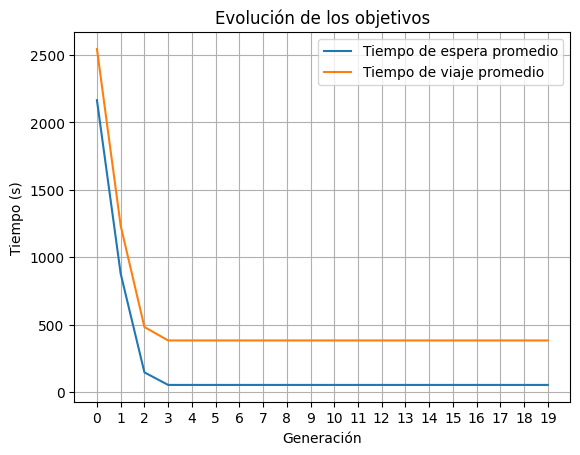

In [ ]:
esperas = [f[0] for f in fitnesses]
viajes = [f[1] for f in fitnesses]

# Por generación
esperas_gen = []
viajes_gen = []

for i in range(ga.generations):
    datos_gen = fitnesses[i*ga.population_size:(i+1)*ga.population_size]
    esperas_gen.append(mean([x[0] for x in datos_gen]))
    viajes_gen.append(mean([x[1] for x in datos_gen]))

plt.plot(esperas_gen, label='Tiempo de espera promedio')
plt.plot(viajes_gen, label='Tiempo de viaje promedio')
plt.xticks(range(0, ga.generations, 1)) 
#plt.xticks([0, 1, 2, ,3, 4, 5. 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]) 
plt.xlabel("Generación")
plt.ylabel("Tiempo (s)")
plt.legend()
plt.title("Evolución de los objetivos")
plt.grid()
plt.show()


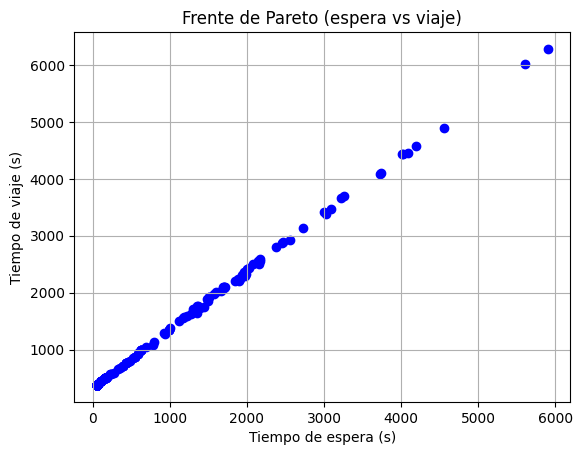

In [12]:
# Al final del algoritmo
esperas = [f[0] for f in fitnesses]
viajes = [f[1] for f in fitnesses]

plt.scatter(esperas, viajes, c='blue')
plt.xlabel('Tiempo de espera (s)')
plt.ylabel('Tiempo de viaje (s)')
plt.title('Frente de Pareto (espera vs viaje)')
plt.grid()
plt.show()


In [ ]:
# mejor fitness
display(best)

(52.8, 382.49999999999994)

In [ ]:
# visualización de una prueba default
prueba = [30, 'GGGGgrrrrrGGGGgrrrrr', 5, 'yyyyyrrrrryyyyyrrrrr', 30, 'rrrrrGGGGgrrrrrGGGGg', 5, 'rrrrryyyyyrrrrryyyyy']
display(prueba)

A continuación se tiene un registro de los experimentos realizados